*Physics Department*, University of Hamburg

# Superconductors: A Machine Learning Approach
Computer applications in physics: AI in physics

*Winter 2023/24*

**Devesh Vaish**

**Muharrem Kilinc**

**Mitulbhai Nandlal Akbari**

Instructor: Prof. Dr. Gregor Kasieczka

February 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import torch.optim as optim
import csv
from prettytable import PrettyTable

import seaborn as sns

In [2]:
# Which device to use for NN calculations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load the data
data1 = pd.read_csv('unique_m.csv')
data2 = pd.read_csv('train.csv')


###This is when we use both the feature###

# features1 = data1.iloc[:, :-2].values
# features2 = data2.iloc[:, :-1].values

# features = np.concatenate((features1 , features2) , axis = 1)

######################################################

###This is when we use feature1###

# features1 = data1.iloc[:, :-2].values
# features = features1

########################################################

###This is when we use feature2###

features2 = data2.iloc[:, :-1].values
features = features2

########################################################

# Extract features and critical temperature
criticalTemp = data1.iloc[:, -2].values

# Convert to PyTorch tensors
X = torch.tensor(features, dtype=torch.float32)
y = torch.tensor(criticalTemp, dtype=torch.float32).reshape(-1, 1)

# Shuffle the data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

# Split the data into training and testing sets
split_size = int(0.8 * len(X))
X_train = X[:split_size]
y_train = y[:split_size]

X_test = X[split_size:]
y_test = y[split_size:]

In [4]:
# Define your neural network
class SuperconductorNN(nn.Module):

    def __init__(self, input_size):
        super(SuperconductorNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 300)
        self.fc2 = nn.Linear(300, 1000)
        self.fc3 = nn.Linear(1000, 1500)
        self.fc4 = nn.Linear(1500, 1000)
        self.fc5 = nn.Linear(1000 , 300)
        # self.fc2 = nn.Linear(1000, 100)
        self.fc6 = nn.Linear(300, 1)

    # def forward(self, x):
    #     x = torch.relu(self.fc1(x))
    #     x = torch.relu(self.fc2(x))
    #     x = torch.relu(self.fc3(x))
    #     x = self.fc4(x)
    #     return x
    def forward(self, x):
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = torch.relu(self.fc3(x))
      x = torch.relu(self.fc4(x))
      x = torch.relu(self.fc5(x))
      x = self.fc6(x)
      return x
# Input size
input_size = features.shape[1]

# Create network object
model = SuperconductorNN(input_size).to(device)

# Loss function
criterion = nn.MSELoss()

# Adam optimiser
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# how many epochs to train for
num_epochs = 500

# how many examples / batch
batch_size = round(len(y_train)/30)

Epoch: 0 / 500 Train Loss: 899.6317443847656 Test Loss: 672.93994140625
Epoch: 1 / 500 Train Loss: 570.4353006998698 Test Loss: 525.5990600585938
Epoch: 2 / 500 Train Loss: 483.7324228922526 Test Loss: 505.1243896484375
Epoch: 3 / 500 Train Loss: 432.3885813395182 Test Loss: 397.32403564453125
Epoch: 4 / 500 Train Loss: 380.81797281901044 Test Loss: 411.3098449707031
Epoch: 5 / 500 Train Loss: 371.4547149658203 Test Loss: 339.27569580078125
Epoch: 6 / 500 Train Loss: 333.38776143391925 Test Loss: 321.46844482421875
Epoch: 7 / 500 Train Loss: 374.8266947428385 Test Loss: 322.68377685546875
Epoch: 8 / 500 Train Loss: 311.1555959065755 Test Loss: 308.0008239746094
Epoch: 9 / 500 Train Loss: 301.1770365397135 Test Loss: 355.2016296386719
Epoch: 10 / 500 Train Loss: 297.76577911376955 Test Loss: 280.5732727050781
Epoch: 11 / 500 Train Loss: 295.5478108723958 Test Loss: 280.0433654785156
Epoch: 12 / 500 Train Loss: 280.65431518554686 Test Loss: 271.3760986328125
Epoch: 13 / 500 Train Loss: 2

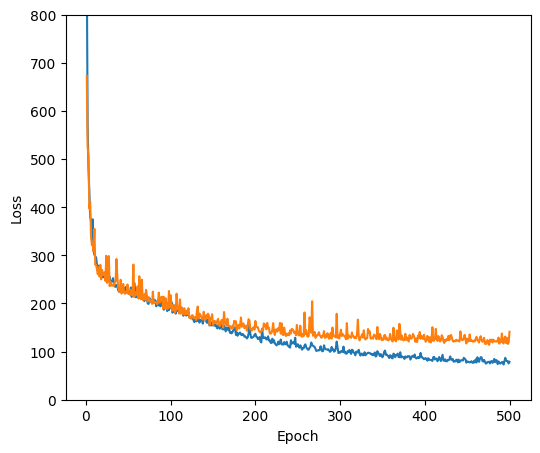

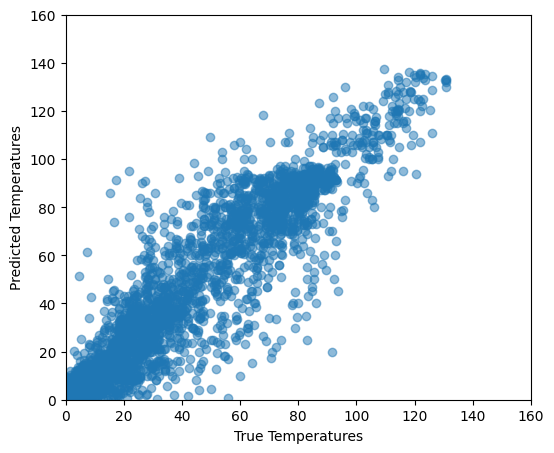

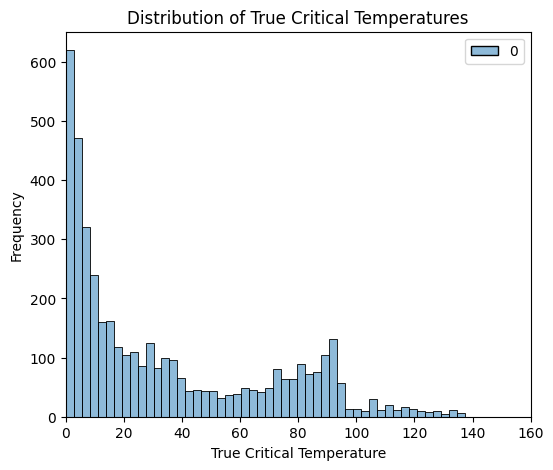

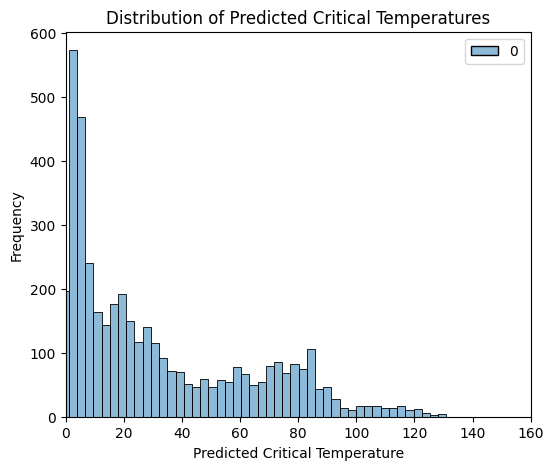

In [5]:
# Keep track of the losses
train_losses = []
test_losses = []

# Lists to store true and predicted values
true_values = []
predicted_values = []

train_examples = X_train.shape[0]
n_batches = int(train_examples / batch_size)

# Loop over the epochs
for ep in range(num_epochs):
    # reorder the training events for each epoch
    idx = np.arange(X_train.shape[0])
    np.random.shuffle(idx)

    X_train = X_train[idx]
    y_train = y_train[idx]

    model.train()

    # Initialize total losses for the epoch
    total_train_loss = 0.0

    # Each epoch is a complete loop over the training data
    for i in range(n_batches):
        # Reset gradient
        optimizer.zero_grad()

        i_start = i * batch_size
        i_stop  = (i + 1) * batch_size

        # Convert x and y to proper objects for PyTorch
        x = X_train[i_start:i_stop].clone().detach().requires_grad_(True).to(torch.float).to(device)
        y = y_train[i_start:i_stop].clone().detach().requires_grad_(True).reshape(-1, 1).to(torch.float).to(device)

        # Apply the network
        net_out = model(x)

        # Calculate the loss function
        loss = criterion(net_out, y)

        # Accumulate the total loss for the epoch
        total_train_loss += loss.item()

        # Calculate the gradients
        loss.backward()

        # Update the weights
        optimizer.step()
    # end of loop over batches

    # Calculate the average training loss for the epoch
    avg_train_loss = total_train_loss / n_batches

    model.eval()

    # Calculate predictions on testing data
    y_pred = model(X_test.clone().detach().requires_grad_(True).to(torch.float).to(device)).cpu().detach().numpy()
    # test_loss = criterion(model(X_test.clone().detach().requires_grad_(True).to(torch.float).to(device)), y_test.to(device)).item()
    test_loss = criterion(torch.from_numpy(y_pred).to(device), y_test.to(device)).item()
    # Update true_values and predicted_values
    true_values.extend(y_test.numpy().flatten())
    predicted_values.extend(y_pred)

    # Append the testing loss to the list
    test_losses.append(test_loss)

    # Append the average training loss to the list
    train_losses.append(avg_train_loss)

    # print some information
    print("Epoch:", ep, "/", num_epochs, "Train Loss:", avg_train_loss, "Test Loss:", test_loss)

# end of loop over epochs

# Plot Loss
plt.figure(figsize=(6, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 800)

# Plot True vs Predicted values
plt.figure(figsize=(6, 5))
plt.scatter(y_pred , y_test, alpha=0.5)
plt.xlabel("True Temperatures")
plt.ylabel("Predicted Temperatures")
plt.xlim(0, 160)
plt.ylim(0, 160)

# Plot Distribution of True Critical Temperatures
plt.figure(figsize=(6, 5))
sns.histplot(y_test, bins=50)
plt.xlabel("True Critical Temperature")
plt.ylabel("Frequency")
plt.title("Distribution of True Critical Temperatures")
plt.xlim(0, 160)

# Plot Distribution of Predicted Critical Temperatures
plt.figure(figsize=(6, 5))
sns.histplot(y_pred, bins=50)
plt.xlabel("Predicted Critical Temperature")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Critical Temperatures")
plt.xlim(0, 160)

plt.show()

np.shape()

In [6]:
data = np.concatenate((y_test,y_pred,) , axis =1)
table = pd.DataFrame(data,
                          data1.iloc[:len(y_test),-1].values,
                          columns=["True critical temperatures" , "Predicted critical temperatures"])

In [7]:
table

,True critical temperatures,Predicted critical temperatures
Ba0.2La1.8Cu1O4,0.600000,10.606642
Ba0.1La1.9Ag0.1Cu0.9O4,2.050000,1.237322
Ba0.1La1.9Cu1O4,11.730000,9.546547
Ba0.15La1.85Cu1O4,17.600000,18.705877
Ba0.3La1.7Cu1O4,60.500000,68.104347
...,...,...
Y0.8Ca0.2Ba2Cu3O6.7,87.000000,79.711609
Y0.8Ca0.2Ba2Cu3O6.6,54.000000,89.703415
Y0.8Ca0.2Ba2Cu3O6.5,14.500000,15.340289
Y0.8Ca0.2Ba2Cu3O6.4,89.800003,73.905869


In [8]:
import base64
import pandas as pd
from IPython.display import HTML

def create_download_link(table, title = "Download CSV file", filename = "data.csv"):
    csv = table.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(table)